In [1]:
is_colab = 'google.colab' in str(get_ipython())
if is_colab:
    !pip install neuron
    !git clone https://github.com/davidfague/Neural-Modeling.git -b cleanup
    %cd Neural-Modeling/scripts
    !pip install neuron_reduce
    !pip install ipympl

In [2]:
import sys
sys.path.append("../")
sys.path.append("../Modules/")

from Modules.simulation import Simulation
from Modules.cell_builder import SkeletonCell, CellBuilder
from Modules.constants import HayParameters

import os
from neuron import h

from logger import Logger

import numpy as np

--No graphics will be displayed.


In [3]:
sim = Simulation(SkeletonCell.Hay)
parameters = HayParameters(sim_name = 'test', h_tstop= 1000, all_synapses_off=True) # NOTE: synapses will crash the simulation since they are not mapped and will remain on deleted sections

In [4]:
%ls

 axial_currents.ipynb   builder_runtime.txt  'Figure 1.png'
 bAP_matching.ipynb     cell_graph.ipynb      reduction.ipynb


In [5]:
try:
    os.system("rm -r x86_64/")
except:
    pass

rm: cannot remove 'x86_64/': No such file or directory


In [6]:
%cd ../scripts

/home/drfrbc/Neural-Modeling/scripts


/home/drfrbc/miniconda3/envs/sim_env/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [7]:
os.system(f"nrnivmodl {sim.cell_type.value['modfiles']} > /dev/null 2>&1")

h.load_file('stdrun.hoc')
h.nrn_load_dll('./x86_64/.libs/libnrnmech.so')

1.0

In [8]:
# Build the cell
logger = Logger(None)
cell_builder = CellBuilder(sim.cell_type, parameters, logger)
cell, _ = cell_builder.build_cell()

(2024-04-26 16:08:43.538095)-[PID: 4005244]–[INFO]: Building SkeletonCell.Hay.
all: [L5PCtemplate[0].soma[0], L5PCtemplate[0].dend[0], L5PCtemplate[0].dend[1], L5PCtemplate[0].dend[2], L5PCtemplate[0].dend[3], L5PCtemplate[0].dend[4], L5PCtemplate[0].dend[5], L5PCtemplate[0].dend[6], L5PCtemplate[0].dend[7], L5PCtemplate[0].dend[8], L5PCtemplate[0].dend[9], L5PCtemplate[0].dend[10], L5PCtemplate[0].dend[11], L5PCtemplate[0].dend[12], L5PCtemplate[0].dend[13], L5PCtemplate[0].dend[14], L5PCtemplate[0].dend[15], L5PCtemplate[0].dend[16], L5PCtemplate[0].dend[17], L5PCtemplate[0].dend[18], L5PCtemplate[0].dend[19], L5PCtemplate[0].dend[20], L5PCtemplate[0].dend[21], L5PCtemplate[0].dend[22], L5PCtemplate[0].dend[23], L5PCtemplate[0].dend[24], L5PCtemplate[0].dend[25], L5PCtemplate[0].dend[26], L5PCtemplate[0].dend[27], L5PCtemplate[0].dend[28], L5PCtemplate[0].dend[29], L5PCtemplate[0].dend[30], L5PCtemplate[0].dend[31], L5PCtemplate[0].dend[32], L5PCtemplate[0].dend[33], L5PCtemplate[0].

In [9]:
from adjacency import get_all_descendants, find_terminal_descendants, get_branching_seg_indices

In [10]:
%matplotlib widget

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interactive, fixed, FloatSlider

# Setup a global reference for figure and axes
fig, ax = None, None

def plot_segments(seg_data, elevation=0, azimuth=-100, radius_scale=1.0, deleted_indices=[]):
    global fig, ax
    if fig is None or ax is None:
        plt.close('all')  # Close any existing plots
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
    else:
        ax.cla()  # Clear the existing axes

    for i, seg in enumerate(seg_data):
        x_points = [seg.coords['p0_0'].iloc[0], seg.coords['pc_0'].iloc[0], seg.coords['p1_0'].iloc[0]]
        y_points = [seg.coords['p0_1'].iloc[0], seg.coords['pc_1'].iloc[0], seg.coords['p1_1'].iloc[0]]
        z_points = [seg.coords['p0_2'].iloc[0], seg.coords['pc_2'].iloc[0], seg.coords['p1_2'].iloc[0]]

        radius = seg.coords['r'].iloc[0] * radius_scale
        color = 'red' if i in deleted_indices else 'black'
        radius = radius*10 if i in deleted_indices else radius
        ax.plot(x_points, z_points, y_points, linewidth=radius, color=color)

    ax.view_init(elev=elevation, azim=azimuth)
    ax.set_xlabel('X')
    ax.set_ylabel('Z')
    ax.set_zlabel('Y')

In [11]:
from Modules.morph_reduction_utils import get_terminal_coordinates, create_segments_to_mech_vals, EXCLUDE_MECHANISMS, disconnect_root, reduce_subtree, calculate_nsegs_from_lambda, apply_params_to_section, create_seg_to_seg, copy_dendritic_mech, average_coordinates, calculate_third_point

In [12]:
adjacency_matrix = cell.compute_directed_adjacency_matrix()

In [13]:
from cell_model import find_nexus_seg
all_segments, seg_data = cell.get_segments(['all'])

nexus_seg_index = find_nexus_seg(cell, adjacency_matrix)
nexus_seg = all_segments[nexus_seg_index]
root_sections_to_reduce = nexus_seg.sec.children()
print(f"root_sections_to_reduce: {root_sections_to_reduce}")

root_sections_to_reduce: [L5PCtemplate[0].apic[50], L5PCtemplate[0].apic[37]]


In [14]:
def reduce_tree(root_section, all_segments, seg_data, adjacency_matrix):
    print(f"Reducing {root_section} and its descendants to single uniform cylindrical cable.")
    # gather the sectuibs and segments to delete.
    root_seg = root_section(0.000001)
    root_seg_index = all_segments.index(root_seg)
    root_seg_descendants_indices = get_all_descendants(adjacency_matrix, start_segment=root_seg_index, descendants=None)
    root_seg_descendants = [all_segments[seg_index] for seg_index in root_seg_descendants_indices]
    root_sec_descendants = list(np.unique([seg.sec for seg in root_seg_descendants]))
    sections_to_delete = np.unique([root_section] + root_sec_descendants) # root_sec will be in root_sec_descendants if root_sec is multiple segments
    deleted_seg_indices = [all_segments.index(seg) for sec in sections_to_delete for seg in sec]
    
    # get 3D coordinates # consider updating to get all the coordinates along the tree?
    terminal_descendant_indices = find_terminal_descendants(adjacency_matrix, start_index=root_seg_index, visited=None, terminal_indices=None)
    original_terminal_seg_coords = get_terminal_coordinates(seg_data, terminal_descendant_indices)
    original_root_seg_coords = seg_data[root_seg_index].coords # have to dissect this correctly
    new_section_begin_coordinates = [original_root_seg_coords.p0_0, original_root_seg_coords.p0_1, original_root_seg_coords.p0_2]
    
    # remove active conductances and get seg_to_mech dictionary that maps the holds mechanism values for the deleted segments
    deleted_segment_mechs_dict = create_segments_to_mech_vals(sections_to_delete=sections_to_delete, remove_mechs=False, exclude=EXCLUDE_MECHANISMS)
    
    # disconnet the root (ascendant/seg_to_reduce_from) from its ascendants. store x to reconnect later.
    root_parent_sec, root_connection_x_loc = disconnect_root(root_section)
    
    # get the new cable properties
    new_cable_properties = reduce_subtree(root_section)
    print(f"new_cable_properties: {new_cable_properties}")
    
    # determine nseg for the new branches
    new_cable_nseg = calculate_nsegs_from_lambda(new_cable_properties)
    
    # create reduced branches
    root_sec_type = str(root_section).split('.')[-1].split('[')[0]
    num_sec_of_root_sec_type = len(getattr(cell, root_sec_type))
    new_section_name  = 'New.' + root_sec_type + '[' + str(num_sec_of_root_sec_type)+ ']'
    new_section = h.Section(name=new_section_name)
    apply_params_to_section(new_section, new_cable_properties, new_cable_nseg)
    new_section.connect(root_parent_sec(root_connection_x_loc), 0)
    getattr(cell, root_sec_type).append(new_section)
    cell.all.append(new_section)
    
    # give 3D coordinates to new section
    average_terminal_coordinates = average_coordinates(original_terminal_seg_coords)
    new_section_end_coordinates = calculate_third_point(new_section_begin_coordinates, average_terminal_coordinates, new_cable_properties.length)
    new_section.pt3dadd(float(new_section_begin_coordinates[0].iloc[0]), float(new_section_begin_coordinates[1].iloc[0]), float(new_section_begin_coordinates[2].iloc[0]), new_section.diam)
    new_section.pt3dadd(float(new_section_end_coordinates[0].iloc[0]), float(new_section_end_coordinates[1].iloc[0]), float(new_section_end_coordinates[2].iloc[0]), new_section.diam)
    
    # deal with synapses

    # create segment to segment mapping
    reduction_frequency=0
    mapping_type = 'impedance'
    original_seg_to_reduced_seg, reduced_seg_to_original_seg = create_seg_to_seg(new_section,
                        root_sec_descendants,
                        root_section,
                        new_cable_properties,
                        mapping_type,
                        reduction_frequency)
    
    # copy active mechanisms
    copy_dendritic_mech(original_seg_to_reduced_seg=original_seg_to_reduced_seg,
                        reduced_seg_to_original_seg=reduced_seg_to_original_seg,
                        segment_to_mech_vals=deleted_segment_mechs_dict,
                        new_section=new_section,
                        mapping_type=mapping_type)
    
    # delete the sections to delete
    for sec in sections_to_delete:
        sec_type = str(sec).split('.')[-1].split('[')[0]
        getattr(cell,sec_type).remove(sec)
        cell.all.remove(sec)
        h.delete_section(sec=sec)
        
    return deleted_seg_indices, new_section

Neuron_Reduce is a new tool for simplifying complex neuron models while enhancing their simulation run-time. It analytically maps the detailed tree into a reduced multi-cylindrical tree, based on Rall's cable theory and linear circuit theory (Fig. 1). The underpinning of the reduction algorithm is that it preserves the magnitude of the transfer impedance $|Z_{0,j} (\omega)|$ from each dendritic location, $j$, to the soma (the dendro-somatic direction, Eqs. (1)--(11) in Methods). Since in linear systems it holds that $|Z_{0,j} (\omega)| = |Z_{j,0} (\omega)|$, for passive dendritic trees it also preserves the transfer impedance in the soma-to-dendritic direction (e.g., current injection at the soma will result in the same voltage response at the respective sites in the detailed and reduced models\(^{59}\)).


Note that dendritic voltage transients (e.g., synaptic potentials) contain a range of frequencies, $\omega$. We however had to select one frequency to use for the mapping of the detailed-to-the-reduced tree. Consequently, we examined a whole range of possible $\omega$ values for this mapping. Conveniently, we found that $\omega = 0$ is the preferred frequency for generating the reduced model (namely, when the mapping from detailed-to-the-reduced model is performed based on the transfer resistance $|Z_{0,j} (\omega = 0)| = |R_{0,j}|$, see Supplementary Fig. 7). This result is actually not surprising; Rinzle and Rail\(^{33}\) showed that, in passive trees and current-based synapses, the attenuation of the voltage time integral (the area below the EPSPs) is identical to the attenuation of steady-state voltage. In other words, when using the transfer resistance for our mapping procedure, we preserved the total charge transfer (which in our case, was proportional to the voltage time integral) from the synapse to the soma (and vice versa), but not, for example, the EPSP peak value.


Neuron_Reduce algorithm and its implementation in NEURON

Neuron_Reduce maps each original stem dendrite to a unique single cylinder with both ends sealed. This cylinder preserves the specific passive cable properties ($R_m$, $C_m$, and $R_a$) of the original tree as well as both the transfer impedance from the electrotonically most distal dendritic tip to the soma and the input resistance at the soma end of the corresponding stem dendrite (when disconnected from the soma). For a sinusoidal angular frequency $\omega > 0$, the transfer impedance $Z_{ij}(\omega)$ is the ratio between the Fourier transform of the voltage at point $i$ and the Fourier transform of the sinusoidal current injected into the injection point $j$ (note that in passive systems, $Z_{ij}(\omega) = Z_{ji}(\omega)$). This ratio is a complex number; its magnitude $|Z_{ij}(\omega)|$ is the ratio (in $\Omega$) between the peak voltage response and the amplitude of the injected current. In a short cylindrical cable with sealed ends and electrotonic length $L$, the transfer impedance $Z_{0,X}(\omega)$, between the somatic end of the cylinder ($X = 0$) and any location $X$ is [33,43,62]


Equation (1):
$$
Z_{0,X} (\omega) = \frac{R_{\infty} \cosh (q (L - X))}{q \sinh(qL)},
$$

where

Equation (2):
$$
R_{\infty} = \frac{2}{\pi} \sqrt{R_m R_a} d^{-\frac{3}{2}},
$$

and

Equation (3):
$$
q = \sqrt{1 + i\omega\tau},
$$

where $\tau$ is the membrane time constant, $R_m C_m$.

From Eq. (1), the input impedance at $(X=0)$ is

Equation (4):
$$
Z_{0,0} (\omega) = \frac{R_{\infty}}{q} \coth(qL).
$$

We next want a cylindrical cable of electrotonic length $L$, in which both $|Z_{0,L} (\omega)|$ and $|Z_{0,0} (\omega)|$ are identical to those measured in the respective original stem dendrite (Fig. 1). For this purpose, we first look for an $L$ value in which the ratio $\frac{|Z_{0,L} (\omega)|}{|Z_{0,0} (\omega)|}$ is preserved. Dividing Eq. (1) by Eq. (4), we get


Equation (5):
$$
\frac{Z_{0,X} (\omega)}{Z_{0,0} (\omega)} = \frac{\cosh(q(L - X))}{\cosh(qL)},
$$

which can be expressed as

Equation (6):
$$
\frac{Z_{0,X} (\omega)}{Z_{0,0} (\omega)} = \frac{\cosh (a(L - X) + i b(L - X))}{\cosh(aL + i bL)} = M \exp(i \phi),
$$


where $a$ and $b$ are the real and the imaginary parts of $q$, respectively, and $M$ and $phi$ are the modulus and phase angle of this complex ratio.

As shown previously\(^{62}\), it follows that

$$
M = \frac{|Z_{0,X} (\omega)|}{|Z_{0,0} (\omega)|} = \left[ \frac{\cosh(2a (L - X)) + \cos(2b (L - X))}{\cosh(2aL) + \cos(2bL)} \right]^{0.5}
$$

and

$$
\phi = \arctan \left[ \frac{\tanh(a (L - X)) \tan(b (L - X))}{1 - \tanh(a (L - X)) \tan(b (L - X))} \right]
$$

Importantly, for a fixed $( M )$ (and a given $( \omega )$) there is a unique value of $( L )$ that satisfies Eq. (7) (see Fig. 4 in ref. $( ^{62} )$ and note the one-to-one mapping between $( M )$ and $( L )$ for a given $( \omega )$ value). However, there are an infinite number of cylindrical cables (with different diameters and lengths) that have identical $( L )$ values preserving a given $( M )$ value in Eq. (7).


We next need a unique cable, with a specific diameter $d$, that also preserves the measured value of $|Z_{0,0}(\omega)|$ (and therefore it also preserves $Z_{0,L}(\omega)$, see Eq. (7)).

From Eqs. (2) and (4) we get

$$
Z_{0,0} (\omega) = \frac{2}{\pi q} \sqrt{R_m R_a} d^{-\frac{3}{2}} \coth(qL)
$$

and thus

$$
|Z_{0,0} (\omega)| = \left| \frac{2}{\pi q} \sqrt{R_m R_a} d^{-\frac{3}{2}} \coth(qL) \right|
$$

from which we compute the diameter, $d$, for that cylinder

$$
|d| = \left( \frac{2}{\pi} \sqrt{R_m R_a} \frac{\coth(qL)}{|Z_{0,0} (\omega)|} \right)^{\frac{2}{3}}.
$$


Equations (1)--(11) provide the unique cylindrical cable (with a specific $d$ and $L$, and the given membrane and axial properties) that preserves the values of $|Z_{0,L} (\omega)|$ and $|Z_{0,0} (\omega)|$ as in the respective stem dendrite. Note that this unique cable does not necessarily preserve the phase ratio ($\phi$ in Eq. (8)) as in the original tree.


In [15]:
all_deleted_seg_indices = []
new_sections = []
for root_section in root_sections_to_reduce:
    deleted_seg_indices, new_section = reduce_tree(root_section, all_segments, seg_data, adjacency_matrix)
    all_deleted_seg_indices.extend(deleted_seg_indices)
    new_sections.append(new_section)

Reducing L5PCtemplate[0].apic[50] and its descendants to single uniform cylindrical cable.
new_cable_properties: CableParams(length=1140.2024431017408, diam=1.6538087750516277, space_const=837.8282558822426, cm=2.0, rm=16977.92869269949, ra=100.0, e_pas=-90.0, electrotonic_length=1.3609023509252438)
Reducing L5PCtemplate[0].apic[37] and its descendants to single uniform cylindrical cable.
new_cable_properties: CableParams(length=702.1941510897877, diam=1.4055829093126275, space_const=772.397022359403, cm=2.0, rm=16977.92869269949, ra=100.0, e_pas=-90.0, electrotonic_length=0.9091103807531908)


Show Reduced Cell

In [16]:
# # Now include the updated plot_segments function in your interactive widget setup
# interactive_plot1 = interactive(plot_segments, 
#                                seg_data=fixed(seg_data),
#                                elevation=(-90, 90, 1),
#                                azimuth=(-180, 180, 1),
#                                radius_scale=FloatSlider(min=0.1, max=5.0, step=0.1, value=1.0),
#                                deleted_indices=fixed(all_deleted_seg_indices))
# interactive_plot1

In [17]:
# new_section.name()
cell.all[-3:]

[L5PCtemplate[0].axon[0], New.apic[109], New.apic[81]]

In [18]:
new_segments = [seg for new_section in new_sections for seg in list(new_section)]

In [19]:
cell.apic[-3:]

[L5PCtemplate[0].apic[108], New.apic[109], New.apic[81]]

In [20]:
all_segments_after_reduction, new_seg_data = cell.get_segments(['all'])

In [21]:
new_seg_indices = []
for seg in new_segments: # new_sections is a list of segments as of writing this
    new_seg_indices.append(all_segments_after_reduction.index(seg))

In [22]:
# # Now include the updated plot_segments function in your interactive widget setup
# interactive_plot = interactive(plot_segments, 
#                                seg_data=fixed(new_seg_data),
#                                elevation=(-90, 90, 1),
#                                azimuth=(-180, 180, 1),
#                                radius_scale=FloatSlider(min=0.1, max=5.0, step=0.1, value=1.0),
#                                deleted_indices=fixed(new_seg_indices))
# interactive_plot

interactive(children=(IntSlider(value=20, description='elevation', max=90, min=-90), IntSlider(value=-100, des…

interactive(children=(IntSlider(value=20, description='elevation', max=90, min=-90), IntSlider(value=-100, des…

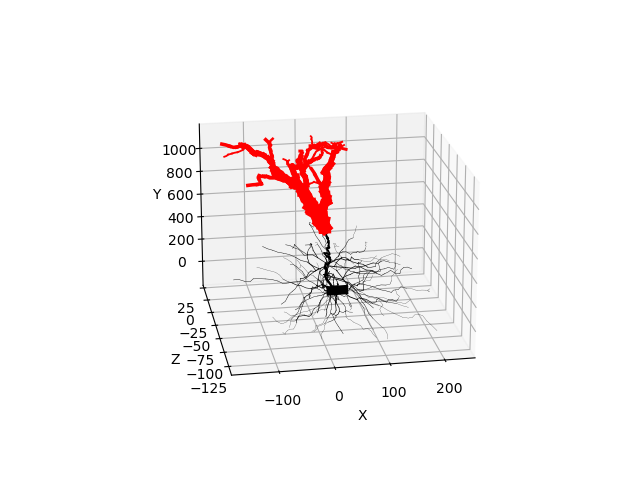

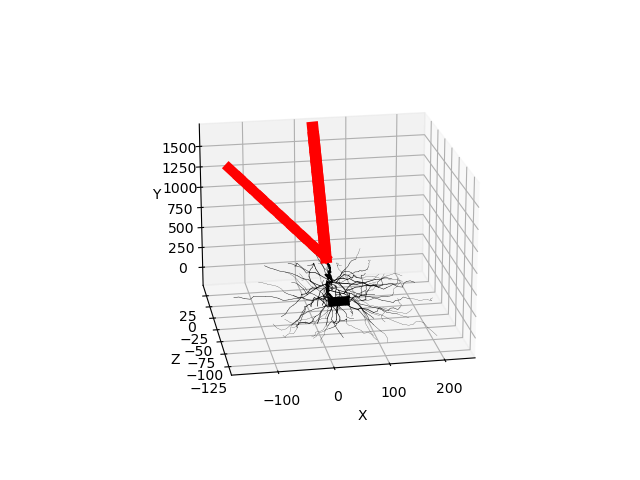

In [23]:
# Ensure %matplotlib widget is enabled for interactive matplotlib in Jupyter
%matplotlib widget

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interactive, FloatSlider, fixed
from IPython.display import display


class Interactive3DPlot:
    def __init__(self):
        # Initialize the plot without showing it
        self.fig, self.ax = plt.subplots(subplot_kw={'projection': '3d'})

    def plot_segments(self, seg_data, elevation=20, azimuth=-100, radius_scale=1.0, deleted_indices=[]):
        self.ax.cla()  # Clear the existing axes

        for i, seg in enumerate(seg_data):
            x_points = [seg.coords['p0_0'].iloc[0], seg.coords['pc_0'].iloc[0], seg.coords['p1_0'].iloc[0]]
            y_points = [seg.coords['p0_1'].iloc[0], seg.coords['pc_1'].iloc[0], seg.coords['p1_1'].iloc[0]]
            z_points = [seg.coords['p0_2'].iloc[0], seg.coords['pc_2'].iloc[0], seg.coords['p1_2'].iloc[0]]

            radius = seg.coords['r'].iloc[0] * radius_scale
            color = 'red' if i in deleted_indices else 'black'
            radius = radius*10 if i in deleted_indices else radius
            self.ax.plot(x_points, z_points, y_points, linewidth=radius, color=color)

        self.ax.view_init(elev=elevation, azim=azimuth)
        self.ax.set_xlabel('X')
        self.ax.set_ylabel('Z')
        self.ax.set_zlabel('Y')

# Create two instances of the plot class for different datasets
plot1 = Interactive3DPlot()
plot2 = Interactive3DPlot()

# Setup interactive widgets for each plot
interactive_plot1 = interactive(plot1.plot_segments, 
                                seg_data=fixed(seg_data),
                                elevation=(-90, 90, 1),
                                azimuth=(-180, 180, 1),
                                radius_scale=FloatSlider(min=0.1, max=5.0, step=0.1, value=1.0),
                                deleted_indices=fixed(all_deleted_seg_indices))

interactive_plot2 = interactive(plot2.plot_segments, 
                                seg_data=fixed(new_seg_data),
                                elevation=(-90, 90, 1),
                                azimuth=(-180, 180, 1),
                                radius_scale=FloatSlider(min=0.1, max=5.0, step=0.1, value=1.0),
                                deleted_indices=fixed(new_seg_indices))

display(interactive_plot1)
display(interactive_plot2)

In [24]:
parameters

HayParameters(sim_name='test', numpy_random_state=130, neuron_random_state=90, h_celcius=37, h_tstop=1000, h_dt=0.1, CI_on=False, CI_target='soma', h_i_amplitude=10.0, h_i_duration=1000, h_i_delay=10, record_ecp=False, record_seg_to_seg=False, all_synapses_off=True, trunk_exc_synapses=True, perisomatic_exc_synapses=True, add_soma_inh_synapses=True, num_soma_inh_syns=150, exc_gmax_mean_0=2.3, exc_gmax_std_0=0.2, exc_gmax_clip=(0, 15), inh_gmax_dist=0.5, soma_gmax_dist=0.5, exc_scalar=1, exc_synaptic_density=2.16, inh_synaptic_density=0.22, use_SA_exc=True, exc_P_release_mean=0.53, exc_P_release_std=0.22, inh_basal_P_release_mean=0.72, inh_basal_P_release_std=0.1, inh_apic_P_release_mean=0.3, inh_apic_P_release_std=0.08, inh_soma_P_release_mean=0.88, inh_soma_P_release_std=0.05, exc_syn_mod='AMPA_NMDA_STP', inh_syn_mod='GABA_AB_STP', exc_mean_fr=4.43, exc_std_fr=2.9, inh_prox_mean_fr=16.9, inh_prox_std_fr=14.3, inh_distal_mean_fr=3.9, inh_distal_std_fr=4.9, exc_syn_params=({'tau_d_AMPA':

In [25]:
os.mkdir(sim.path)

In [26]:
parameters.path = os.path.join(sim.path, parameters.sim_name)

In [27]:
parameters.path

'SkeletonCell.Hay-26-04-2024-16-08-41/test'

In [28]:
sim.set_all_recorders(cell, parameters)

In [29]:
sim.simulate(cell, parameters)

(2024-04-26 16:08:52.427327)-[PID: 4005244]–[INFO]: Starting simulation.
(2024-04-26 16:08:55.661204)-[PID: 4005244]–[INFO]: Saving data at step: 10000
(2024-04-26 16:08:55.691748)-[PID: 4005244]–[INFO]: Finished writing data
(2024-04-26 16:08:55.692149)-[PID: 4005244]–[INFO]: Finished clearing recorders
(2024-04-26 16:08:55.695976)-[PID: 4005244]–[INFO]: Finish simulation in {simulation_runtime}


In [30]:
import pickle
with open(os.path.join(parameters.path, "parameters.pickle"), "wb") as file:
    pickle.dump(parameters, file)

In [31]:
import analysis
soma_spikes = analysis.DataReader.read_data(parameters.path, "soma_spikes")

In [32]:
v = analysis.DataReader.read_data(parameters.path, "v")

In [33]:
v[0]

array([-90.        , -89.14775454, -88.15338349, ..., -77.16527208,
       -77.165343  , -77.1654138 ])

Some Notes: 
Compare detailed and reduced
Try allen database cell
1. We adapted neuron_reduce for more user-control.
2. Currently not Mapping synapses, but it will be easy to add.
3. We could convert single-cylinders into an equivalent set of nbranches.